/rdfs/fast/home/sunyingge/anaconda3/envs/tp/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[0616 15:07:25 @collection.py:146] New collections created in tower : tf.GraphKeys.REGULARIZATION_LOSSES of size 106
[0616 15:07:25 @collection.py:165] These collections were modified but restored in : (tf.GraphKeys.SUMMARIES: 0->1)
INFO:tensorflow:Restoring parameters from /rdfs/fast/home/sunyingge/data/models/workdir_0611/SEResUNET_0613_1205_20/model-149644
Result file already exists. Press enter to             continue and overwrite it when inference is done...


  0%|          | 0/94217 [00:00<?, ?it/s]

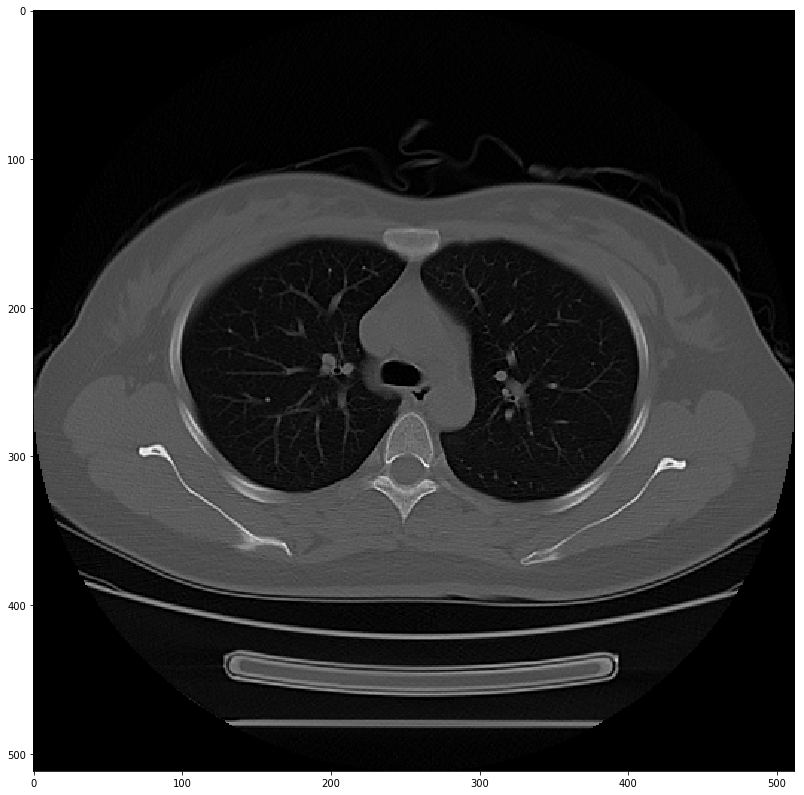

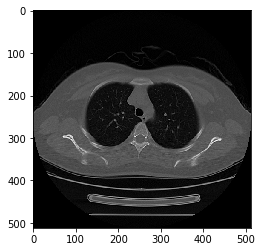

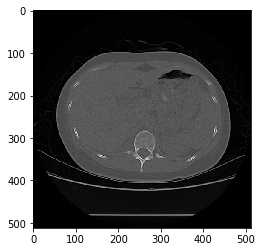

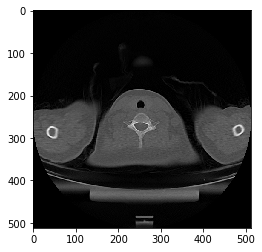

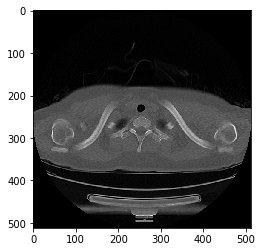

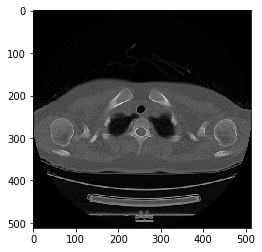

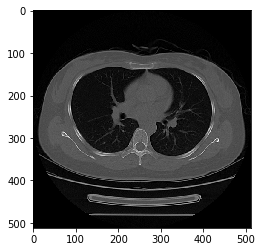

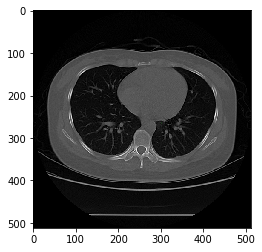

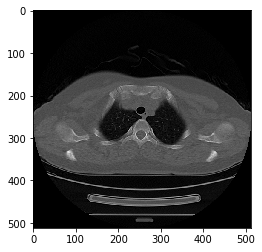

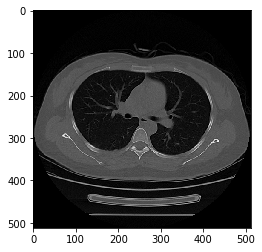

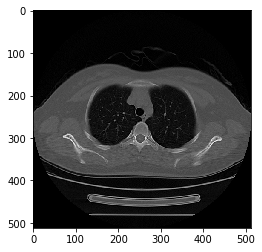

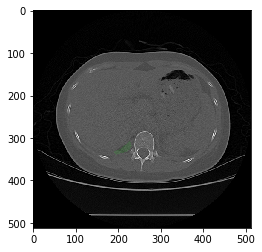

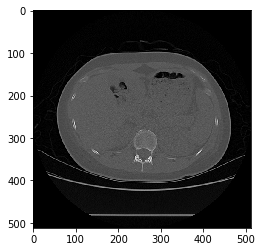

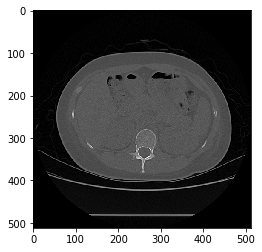

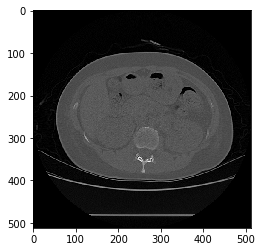

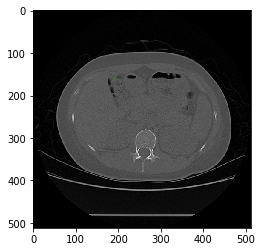

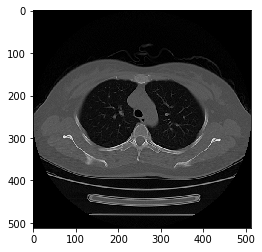

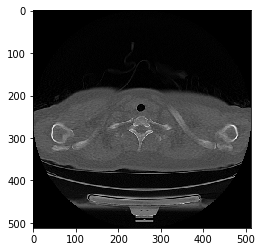

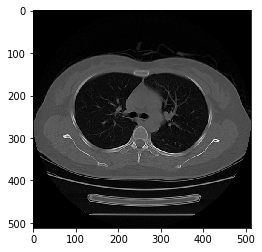

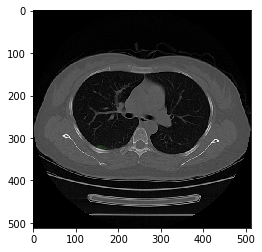

  0%|          | 32/94217 [01:40<81:46:41,  3.13s/it]

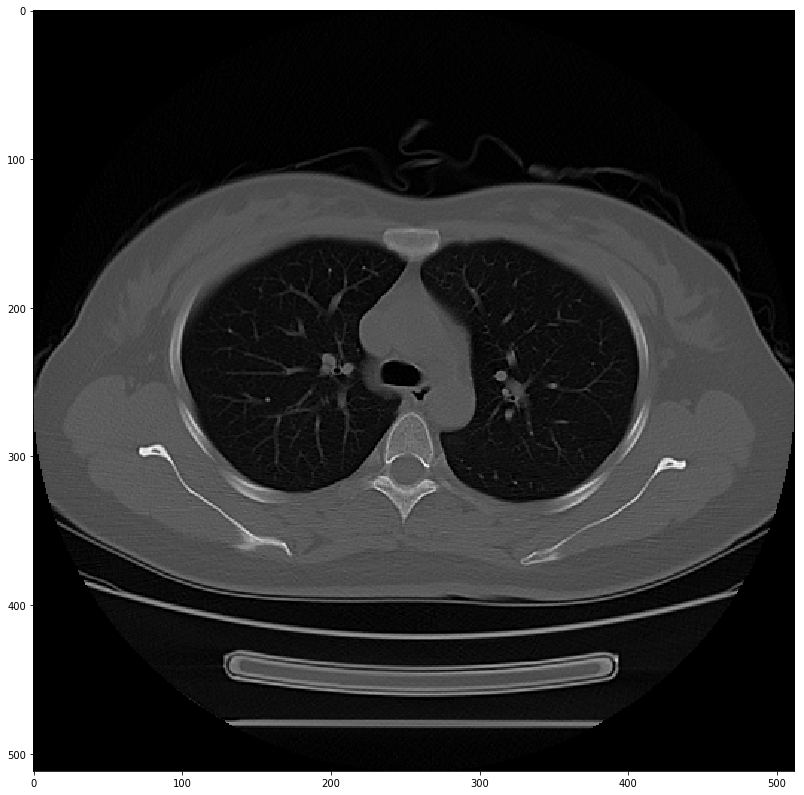

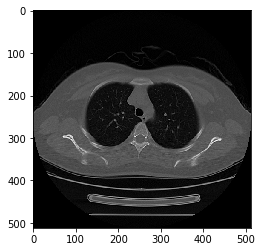

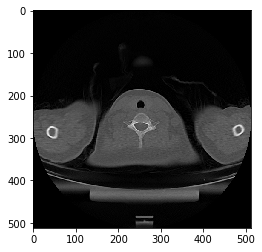

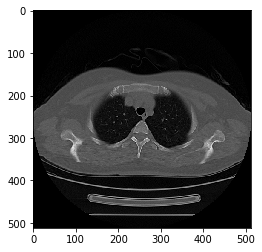

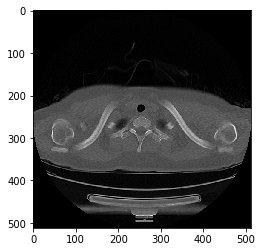

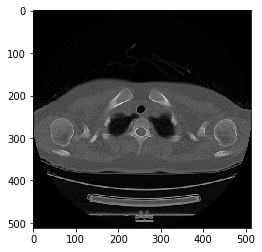

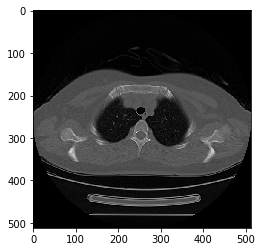

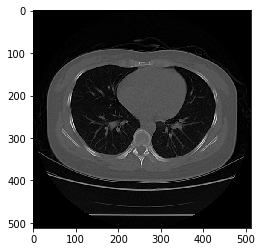

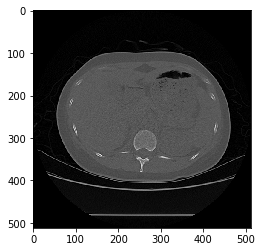

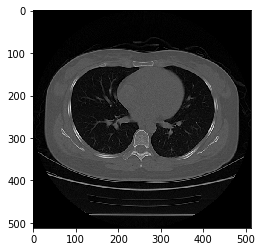

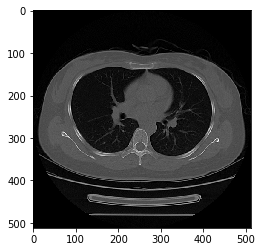

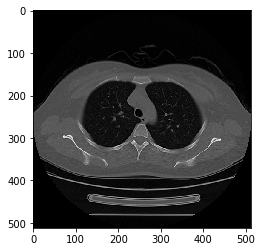

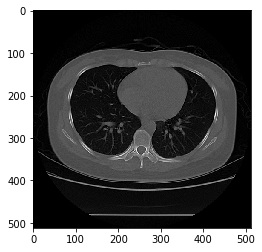

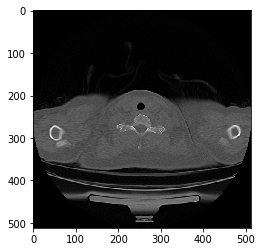

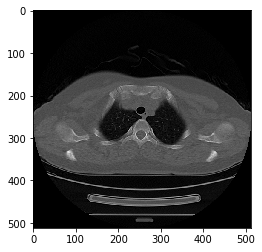

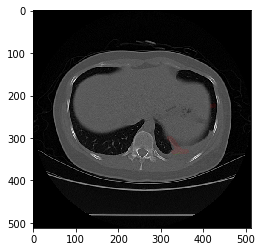

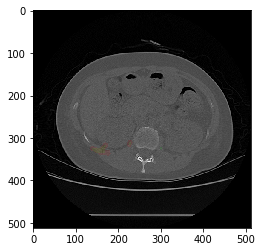

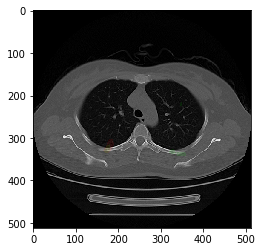

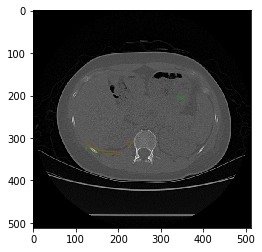

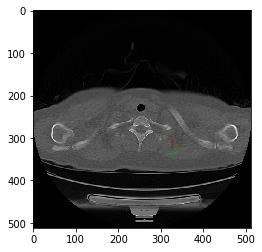

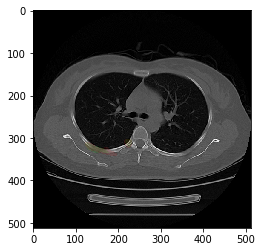

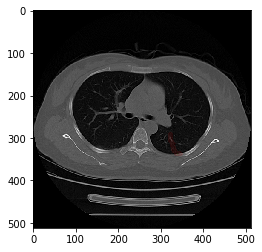

IndexError: index 32 is out of bounds for axis 0 with size 32

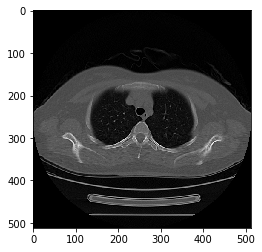

In [1]:
%matplotlib inline
import argparse, os, shutil, time
import multiprocessing as mp
from collections import defaultdict
from os.path import join as pj

import numpy as np
import tensorflow as tf
from tqdm import tqdm

# from tensorpack.dataflow import MultiProcessMapData, BatchData
from tensorpack.train import TrainConfig, launch_train_with_config, SyncMultiGPUTrainerParameterServer
from tensorpack.train import SyncMultiGPUTrainerReplicated, SimpleTrainer
from tensorpack.tfutils import SmartInit
from tensorpack.callbacks import ModelSaver, ScheduledHyperParamSetter, GPUUtilizationTracker, PeriodicCallback
from tensorpack.callbacks import MergeAllSummaries, ScalarPrinter, TFEventWriter, JSONWriter, ProgressBar
from tensorpack.utils import logger
from tensorpack.utils.gpu import get_num_gpu
from tensorpack import QueueInput

import sys
sys.path.insert(0, "../..")
from data import PneuSegDF
from tp_model import Tensorpack_model
from fw_dependent.tf.model.tf_layers import tf_model_v2
from fw_dependent.tf.tools.train_tf_lowlevel import evaluation
from fw_neutral.utils.config import Config
from fw_neutral.utils.data_proc import Pneu_type, im_normalize
from fw_neutral.utils.metrics import Evaluation
from fw_neutral.utils.viz import viz_patient

from tensorpack.dataflow import TestDataSpeed, PrintData

def parse_args():
    parser = argparse.ArgumentParser("""
        "test" mode requires:
            "--gpus_to_use"
            "--train_dir"
            and "--batch_size" optionally
        
        "tp_eval" mode require:
    """)
    parser.add_argument("mode", choices=["train", "sess_eval", "test"])
    parser.add_argument("config", help="Config file.")
    parser.add_argument("--gpus_to_use", nargs='+')
    parser.add_argument("-o", "--output_dir",
        default="/rdfs/fast/home/sunyingge/data/models/workdir_0611/SEResUNET_")
    parser.add_argument("--train_dir", help="Training set directory.",
        # default="/rdfs/fast/home/sunyingge/data/COV_19/prced_0512/Train_0608/"
        default="/rdfs/fast/home/sunyingge/data/COV_19/prced_0512/Train_0613/"
        )
    parser.add_argument("--train_debug", action="store_true")

    parser.add_argument("--resume", default="")
    parser.add_argument("--resume_epoch", help="Checkpoint epoch plus one.", default=1)

    # Eval mode related
    parser.add_argument("--testset_dir", nargs='+',
        # default=["/rdfs/fast/home/sunyingge/data/COV_19/0508/TestSet/0519/normal_pneu_datasets",
        # "/rdfs/fast/home/sunyingge/data/COV_19/0508/TestSet/0519/covid_pneu_datasets"]
        # default=["/rdfs/fast/home/sunyingge/data/COV_19/0508/TestSet/healthy_datasets"]
        default="/rdfs/fast/home/sunyingge/data/COV_19/prced_0512/Test_0616"
        )
    parser.add_argument("--batch_size", type=int,
        help="Provided here to enable easy overwritting (particularly useful for evaluation).")
    parser.add_argument("--model_file",
        default="/rdfs/fast/home/sunyingge/data/models/workdir_0611/SEResUNET_0612_1451_14/model-4823"
        )
    parser.add_argument("--eval_multi", action="store_true", default=True)
    parser.add_argument("--model_folder",
        default="/rdfs/fast/home/sunyingge/data/models/workdir_0611/SEResUNET_0613_1205_20/")
    parser.add_argument("--model_list", nargs='+',
        default=["model-149644"])
    parser.add_argument("--tp_eval", action="store_true", default=True)

    parser.add_argument("--min_num_workers", type=int, default=2)
    parser.add_argument("--viz", default=True)

    return parser.parse_args(["sess_eval", 
                              "/rdfs/fast/home/sunyingge/data/models/workdir_0611/SEResUNET_0613_1205_20/UNet_0611.json",
                             "--gpus_to_use", "7", "--batch_size", "32"])

def train(args, cfg):
    df = PneuSegDF(args, cfg)
    num_gpu = max(get_num_gpu(), 1)
    print(f"\nNumber of training samples: {len(df)}\n")
    ds = df.prepared(num_gpu, cfg.batch_size)
    schedule = [(ep + 1, lr / num_gpu) for ep, lr in zip([0] + cfg.optimizer["epoch_to_drop_lr"], cfg.optimizer["lr"])]
    if os.path.exists(os.path.dirname(args.resume)):
        assert args.resume_epoch != 1
        output_dir = os.path.dirname(args.resume)
    else:
        output_dir = args.output_dir + time.strftime("%m%d_%H%M_%S", time.localtime())
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    # Avoid overriding config file
    if os.path.exists(pj(output_dir, os.path.basename(args.config))):
        input("Config file will NOT be overwritten. Press Enter to continue...")
    else:
        shutil.copy(args.config, output_dir)
    logger.set_logger_dir(pj(output_dir, "log"))
    train_cfg = TrainConfig(
        model=Tensorpack_model(cfg),
        data=QueueInput(ds),
        steps_per_epoch=len(ds) // num_gpu + 1,
        callbacks=[
            # PeriodicCallback overwritten the frequency of what's wrapped
            PeriodicCallback(ModelSaver(50, checkpoint_dir=output_dir), every_k_epochs=1),
            ScheduledHyperParamSetter("learning_rate", schedule),
            GPUUtilizationTracker(),
            MergeAllSummaries(1 if args.train_debug else 0),
            # ProgressBar(["Loss"])
            ],
        monitors=[
            # ScalarPrinter(True, whitelist=["Loss", "LR"]),
            ScalarPrinter(True),
            # ScalarPrinter(),
            TFEventWriter(), 
            # JSONWriter()
            ],
        max_epoch=cfg.max_epoch,
        session_init=SmartInit(args.resume),
        starting_epoch=args.resume_epoch
    )
    launch_train_with_config(train_cfg, 
        SyncMultiGPUTrainerReplicated(num_gpu) if num_gpu > 1 else SimpleTrainer())

def tp_evaluation(args, cfg, sess, model):
    num_gpu = get_num_gpu()
    df = PneuSegDF(args, cfg, args.testset_dir)
    ds = df.eval_prepared(num_gpu, args.batch_size)
    tf.train.Saver().restore(sess, args.model_file)
    if os.path.exists(args.pkl_dir):
        input("Result file already exists. Press enter to \
            continue and overwrite it when inference is done...")
    pbar = tqdm(total=len(ds))
    ds.reset_state()
    # for i in range(0, len(ds), cfg.batch_size):
    #     batch = ds[i:i + cfg.batch_size]
    #     pbar.update(cfg.batch_size)
    in_ims, in_gts, p_ids, in_og_ims = [], [], [], []
    pneu_eval = Evaluation()
    for idx, in_data in enumerate(ds):
        if not df.ex_process.og_shape:
            df.ex_process.og_shape = in_data[1].shape[:-1]
        in_ims.append(in_data[0])
        in_gts.append(in_data[1])
        if args.viz:
            in_og_ims.append(in_data[4])
        df.ex_process.tl_list.append(in_data[2])
        pneu_eval.add_to_p_map(in_data[3])
        p_id = in_data[3].split('/')[-3]
        p_ids.append(p_id)
        if len(in_ims) == cfg.batch_size or idx == len(ds) - 1:
            im_batch, in_gts = np.array(in_ims), np.array(in_gts)
            pred = sess.run(model.pred["seg_map"], feed_dict={model.in_im: im_batch})
            pred = (1 / (1 + np.exp(-pred))) > .5
            pred = df.ex_process.batch_postprocess(pred)
            if args.viz:
                og_im_batch = np.array(in_og_ims)
                og_im_batch = im_normalize(og_im_batch, cfg.preprocess["normalize"]["ct_interval"],
                    cfg.preprocess["normalize"]["norm_by_interval"])
                viz_patient(og_im_batch, pred, in_gts, True)
            intersection = pred * in_gts
            for i in range(pred.shape[0]):
                pneu_eval.person_map[p_ids[i]].pixel_info["intersection"] += np.sum(intersection[i,:,:,:])
                pneu_eval.person_map[p_ids[i]].pixel_info["gt_area"] += np.sum(in_gts[i,:,:,:])
                pneu_eval.person_map[p_ids[i]].pixel_info["pred_area"] += np.sum(pred[i,:,:,:])
            pbar.update(cfg.batch_size)
            in_ims, in_gts = [], []
        if idx == len(ds) - 1:
            break
        # if idx == 1000: break
    pbar.close()
    pneu_eval.pixel_wise_result()

if __name__ == "__main__":
    mp.set_start_method("spawn")
    args = parse_args()
    os.environ["CUDA_VISIBLE_DEVICES"] = ','.join(args.gpus_to_use)
    cfg = Config()
    cfg.load_from_json(args.config)
    if args.batch_size:
        cfg.batch_size = args.batch_size
    if args.mode == "train":
        train(args, cfg)
    elif args.mode == "sess_eval":
        args.thickness_thres = 3.0
        args.eval_debug = False
        config = tf.ConfigProto(allow_soft_placement=True)
        config.gpu_options.allow_growth = True
        config.gpu_options.per_process_gpu_memory_fraction = 0.95
        sess = tf.Session(config=config)
        # Change this to use towercontext-model.build_graph(placeholders) for consistency
        # Refer to tp doc inference section for details
        # model = tf_model_v2(cfg, False)
        model = Tensorpack_model(cfg)
        model.build_inf_graph()
        if args.eval_multi:
            for mname in args.model_list:
                args.model_file = pj(args.model_folder, mname)
                args.pkl_dir = args.model_file + "_res.pkl"
                if args.tp_eval:
                    tp_evaluation(args, cfg, sess, model)
                else:
                    evaluation("eval_multi", sess, args, cfg, model)
                print(f"\nFinished evaluating {mname}.\n")
        else:
            args.pkl_dir = args.model_file + "_res.pkl"
            evaluation("eval_multi", sess, args, cfg, model)
    elif args.mode == "test":
        df = PneuSegDF(args, cfg)
        num_gpu = max(get_num_gpu(), 1)
        ds = df.eval_prepared(num_gpu, cfg.batch_size)
        print(len(ds))
        TestDataSpeed(ds, 30169).start()